In [9]:
from deepface import DeepFace
import cv2
import numpy as np
import pandas as pd
import csv, os, re, time, logging, cv2, torch
from pathlib import Path
from importlib.metadata import version
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image
from moviepy.editor import VideoFileClip


KeyboardInterrupt



In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob

# Constants
SEQUENCE_LENGTH = 10
STRIDE = 5
BATCH_SIZE = 32

# Helper function to create random sequences
def create_sequences(features, labels, sequence_length, stride):
    x_sequences, y_sequences = [], []
    for i in range(0, len(features) - sequence_length + 1, stride):
        x_sequences.append(features[i:i + sequence_length])
        y_sequences.append(labels[i:i + sequence_length])
    return np.array(x_sequences), np.array(y_sequences)

# Initialize lists to hold all sequences
all_x_sequences = []
all_y_sequences = []

input_files = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_input.csv'))
label_files = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_BORIS.csv'))

# Process each pair of input and label files
for input_file, label_file in zip(input_files, label_files):
    # Load data
    input_df = pd.read_csv(input_file)
    label_df = pd.read_csv(label_file)
    
    # Prepare features and labels
    features = input_df.values
    labels = label_df.values
    
    # Ensure alignment of frames
    if features.shape[0] != labels.shape[0]:
        print(f"Mismatch in frames: {input_file}, {label_file}")
        continue
    
    # Sample sequences
    x_sequences, y_sequences = create_sequences(features, labels, SEQUENCE_LENGTH, STRIDE)
    # Append to global lists
    all_x_sequences.append(x_sequences)
    all_y_sequences.append(y_sequences)


# Concatenate all sequences from all files
all_x_sequences = np.concatenate(all_x_sequences, axis=0)
all_y_sequences = np.concatenate(all_y_sequences, axis=0)

# Convert to TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((all_x_sequences, all_y_sequences))
dataset = dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Verify the dataset
for x_batch, y_batch in dataset.take(1):
    print(f'Feature batch shape: {x_batch.shape}')
    print(f'Label batch shape: {y_batch.shape}')


Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)


In [48]:
dataset.cardinality().numpy()

30

In [49]:
for x_batch, y_batch in dataset.take(30):
    print(f'Feature batch shape: {x_batch.shape}')
    print(f'Label batch shape: {y_batch.shape}')

Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature ba

In [50]:
INPUT_DIM = all_x_sequences.shape[2]  # Number of features per frame (e.g., biosignals + embeddings)
OUTPUT_DIM = all_y_sequences.shape[2] 

In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQUENCE_LENGTH, INPUT_DIM)),    # Input shape: (sequence_length, features)
    tf.keras.layers.LSTM(64, return_sequences=True),              # LSTM layer to capture temporal patterns
    tf.keras.layers.Dense(32, activation='relu'),                 # Dense layer to reduce dimensionality
    tf.keras.layers.Dense(OUTPUT_DIM, activation='sigmoid')       # Output layer with sigmoid for continuous values between 0 and 1
])

In [52]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [57]:
history = model.fit(dataset, epochs=50)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 456.5042 - mae: 5.4055
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 416.8343 - mae: 5.0750
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 425.4049 - mae: 5.2183
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 431.1090 - mae: 5.1918
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 400.8997 - mae: 4.8577
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 406.5817 - mae: 4.9576 
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 446.0112 - mae: 5.3402
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 403.0129 - mae: 4.8519
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 410.6412 - mae: 4.9986
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 420.0264 - mae: 5.0620
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 442.5805 - mae: 5.3035
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 414.6101 - mae: 5.0074
Epoch 13/50
30/30 ━━━━━

In [58]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,276 (1.73 MB)

 Trainable params: 150,758 (588.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 301,518 (1.15 MB)

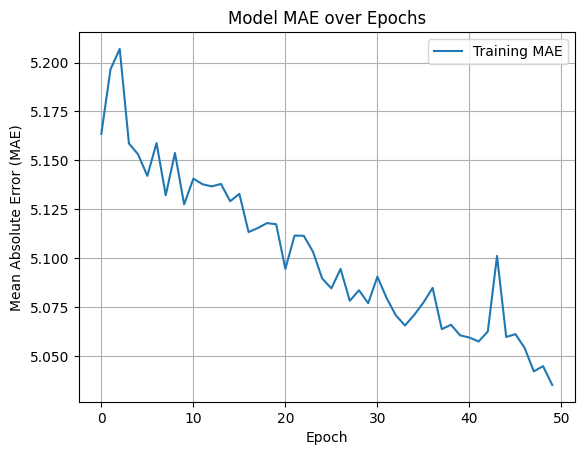

In [59]:
import matplotlib.pyplot as plt

# After training, 'history' holds the metrics for each epoch
# Plot MAE from the training history

# Access 'mae' values for each epoch
mae = history.history['mae']  # MAE for training data
# If you had validation data, access validation MAE as well
# val_mae = history.history['val_mae']

# Plot training MAE
plt.plot(mae, label='Training MAE')
# Uncomment below if you have validation data to compare
# plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model MAE over Epochs')
plt.legend()
plt.grid()
plt.show()
